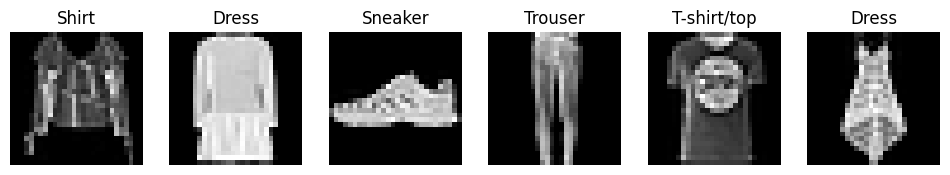

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Трансформации (нормализация в [0,1])
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Визуализация первых картинок
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

images, labels = next(iter(trainloader))
fig, axes = plt.subplots(1, 6, figsize=(12,2))
for i in range(6):
    axes[i].imshow(images[i][0], cmap="gray")
    axes[i].set_title(classes[labels[i]])
    axes[i].axis("off")
plt.show()



In [23]:
import torch.nn as nn
import torch.nn.functional as F

class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 канал (ч/б изображение) → 32 карты признаков
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # уменьшаем размер в 2 раза
        self.dropout = nn.Dropout(0.25)

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # после 2х пулингов картинка 28→14→7
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))    # [batch, 32, 28, 28]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 14, 14]
        x = self.pool(x)             # [batch, 64, 7, 7]
        x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7)   # раскладываем в вектор
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [24]:
model = FashionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for xb, yb in trainloader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")


Epoch 1, Loss: 0.4746
Epoch 2, Loss: 0.3065
Epoch 3, Loss: 0.2687
Epoch 4, Loss: 0.2433
Epoch 5, Loss: 0.2257
Epoch 6, Loss: 0.2086
Epoch 7, Loss: 0.1943
Epoch 8, Loss: 0.1812
Epoch 9, Loss: 0.1718
Epoch 10, Loss: 0.1626


In [25]:
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in testloader:
        outputs = model(xb)
        _, predicted = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()

print("CNN Test Accuracy:", correct / total)


CNN Test Accuracy: 0.9176
